# Image Captioning with Conditioned LSTM Generators

The goal is for a neural net to generate text describing an image it has never seen. This is accomplished by training a LSTM on pairs of image-caption data.

Built off a framework provided by Yassine Benajiba (<yb2235@cs.columbia.edu>), this project was completed as part of the Natural Language Processing course at Columbia University in the fall of 2020.

Data used is the flickr8k data set, described here in more detail: 

> M. Hodosh, P. Young and J. Hockenmaier (2013) "Framing Image Description as a Ranking Task: Data, Models and Evaluation Metrics", Journal of Artificial Intelligence Research, Volume 47, pages 853-899 http://www.jair.org/papers/paper3994.html when discussing our results

Use of the dataset is limited, and it is not provided in this repository. Access can be requested here: https://forms.illinois.edu/sec/1713398

##Preliminaries

In [1]:
import os
from collections import defaultdict
import numpy as np
import PIL
from matplotlib import pyplot as plt
%matplotlib inline

from keras import Sequential, Model
from keras.layers import Embedding, LSTM, Dense, Input, Bidirectional, RepeatVector, Concatenate, Activation
from keras.activations import softmax
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences

from keras.applications.inception_v3 import InceptionV3

from keras.optimizers import Adam

from google.colab import drive

In [2]:
my_data_dir="hw5_data"
drive.mount('/content/gdrive')

def load_image_list(filename):
    with open(filename,'r') as image_list_f: 
        return [line.strip() for line in image_list_f]    

train_list = load_image_list('/content/gdrive/My Drive/'+my_data_dir+'/Flickr_8k.trainImages.txt')
dev_list = load_image_list('/content/gdrive/My Drive/'+my_data_dir+'/Flickr_8k.devImages.txt')
test_list = load_image_list('/content/gdrive/My Drive/'+my_data_dir+'/Flickr_8k.testImages.txt')
len(train_list), len(dev_list), len(test_list)

IMG_PATH = "/content/gdrive/MyDrive/hw5_data/Flickr8k_Dataset"


Mounted at /content/gdrive


Here we can see an example of the images we are using.

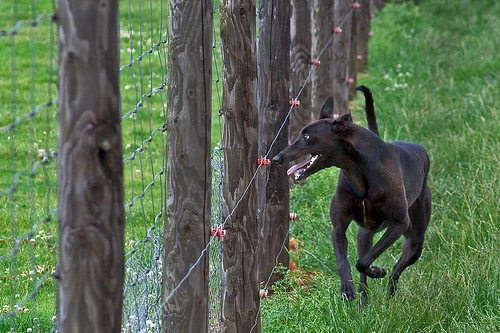

In [3]:
image = PIL.Image.open(os.path.join(IMG_PATH, dev_list[20]))
image 

##Image Encoding
This project uses the Inception V3 network. Here is more detail about this model:

>Szegedy, C., Vanhoucke, V., Ioffe, S., Shlens, J., & Wojna, Z. (2016). Rethinking the inception architecture for computer vision. In Proceedings of the IEEE conference on computer vision and pattern recognition (pp. 2818-2826). https://www.cv-foundation.org/openaccess/content_cvpr_2016/html/Szegedy_Rethinking_the_Inception_CVPR_2016_paper.html


###Formatting

Inception takes as input a 299x299x3 array as input, so the flickr data has to be resized.

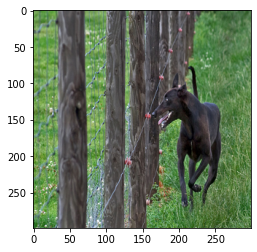

In [8]:
def get_image(image_name):
    image = PIL.Image.open(os.path.join(IMG_PATH, image_name))
    return np.asarray(image.resize((299,299))) / 255.0  

new_image = get_image(dev_list[20]) 
plt.imshow(new_image)

###Transfer Learning


Load the Inception model. We will use the pre-trained weights, as the Inception model was trained on a similar domain of data as the flickr dataset, and should save a lot of time and resources.

In [9]:
img_model = InceptionV3(weights='imagenet')
img_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 149, 149, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 149, 149, 32) 96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 149, 149, 32) 0           batch_normalization_94[0][0]     
_______________________________________________________________________________________

The Inception model is trained to output a softmax output vector of size 1000, representing 1000 different object types (like birds, books, hammers, etc). 

We don't need this last layer because we are not interested in classification, but  the second-to-last layer should contain representation of patterns or objects whose linear combinations generate the classification. The hope is this pentultimate layer represents "sub-objects" like wings, paper, or metal, meaning our LSTM doesn't need to learn how to see in general.

Hence, we make a new model whose output is the second-to-last layer of the Inception model. This functions as an encoder of 299x299x3 images into 2048-length vectors.

In [10]:
new_input = img_model.input
new_output = img_model.layers[-2].output
img_encoder = Model(new_input, new_output)

encoded_image = img_encoder.predict(np.array([new_image]))
print(encoded_image)
print(encoded_image.shape)

[[0.638067   0.48873085 0.0552626  ... 0.6425583  0.2959528  0.49004325]]
(1, 2048)


###Encoded Image Matrix

We use a generator to build the embedded data matrix.

In [11]:
def img_generator(img_list):
    for img in img_list:
      yield np.array([get_image(img)])

enc_train = img_encoder.predict_generator(img_generator(train_list), steps=len(train_list), verbose=1)
enc_dev = img_encoder.predict_generator(img_generator(dev_list), steps=len(dev_list), verbose=1)
enc_test = img_encoder.predict_generator(img_generator(test_list), steps=len(test_list), verbose=1)

np.save("gdrive/My Drive/"+my_data_dir+"/outputs/encoded_images_train.npy", enc_train)
np.save("gdrive/My Drive/"+my_data_dir+"/outputs/encoded_images_dev.npy", enc_dev)
np.save("gdrive/My Drive/"+my_data_dir+"/outputs/encoded_images_test.npy", enc_test)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1976: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


1000/1000 [==============================] - 275s 275ms/step


##Text Encoding

Along with every image in the dataset is a caption. 

In [12]:
def read_image_descriptions(filename):    
  image_descriptions = defaultdict(list)    
  f = open(filename,'r')
  for line in f:
    tokens = line.split()
    path = tokens[0][0:-2]
    tokens[0] = '<START>'
    tokens.append('<END>')
    image_descriptions[path].append([token if i == 0 or i == len(tokens)-1 else token.lower() for i,token in enumerate(tokens)])
  return image_descriptions

descriptions = read_image_descriptions("gdrive/My Drive/"+my_data_dir+"/Flickr8k.token.txt")
print(descriptions[dev_list[0]])

[['<START>', 'the', 'boy', 'laying', 'face', 'down', 'on', 'a', 'skateboard', 'is', 'being', 'pushed', 'along', 'the', 'ground', 'by', 'another', 'boy', '.', '<END>'], ['<START>', 'two', 'girls', 'play', 'on', 'a', 'skateboard', 'in', 'a', 'courtyard', '.', '<END>'], ['<START>', 'two', 'people', 'play', 'on', 'a', 'long', 'skateboard', '.', '<END>'], ['<START>', 'two', 'small', 'children', 'in', 'red', 'shirts', 'playing', 'on', 'a', 'skateboard', '.', '<END>'], ['<START>', 'two', 'young', 'children', 'on', 'a', 'skateboard', 'going', 'across', 'a', 'sidewalk', '<END>']]


Neural nets are matrices of numbers, so we need to represent words in the form of numbers. A simple way to do this is to just enumerate the dictionary for your corpus, and let the net do any feature embedding.

In [13]:
id_to_word = {}
word_to_id = {}

word_set = set()
for sentences in descriptions.values():
  for sentence in sentences:
    for token in sentence:
      word_set.add(token)
word_list = list(word_set)
word_list.sort()
id_to_word[0] = ''
word_to_id[''] = 0
for id, word in enumerate(word_list):
  id_to_word[id + 1] = word
  word_to_id[word] = id + 1

In [14]:
word_to_id['dog'] # should print an integer ID

2310

In [15]:
id_to_word[1984] # should print a word

'crowns'

###Blind Text Generation
First we train the model to generate captions without conditioning the ouput on an image. This is like asking someone to give an answer without knowing what the question is, but since our model is frequentist, this blind output mirrors the overall distribution of the dataset, and we should expect the output to be a very generic caption containing highly frequent words.

In [16]:
max(len(description) for image_id in train_list for description in descriptions[image_id])

40

In [17]:
MAX_LEN = 40
EMBEDDING_DIM=300
vocab_size = len(word_to_id)

text_input = Input(shape=(MAX_LEN,))
embedding = Embedding(vocab_size, EMBEDDING_DIM, input_length=MAX_LEN)(text_input)
x = Bidirectional(LSTM(512, return_sequences=False))(embedding)
pred = Dense(vocab_size, activation='softmax')(x)
model = Model(inputs=[text_input],outputs=pred)
model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])

model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 40)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 40, 300)           2676300   
_________________________________________________________________
bidirectional (Bidirectional (None, 1024)              3330048   
_________________________________________________________________
dense (Dense)                (None, 8921)              9144025   
Total params: 15,150,373
Trainable params: 15,150,373
Non-trainable params: 0
_________________________________________________________________


The text generator.

In [18]:
def text_training_generator(batch_size=128):
  n = 0
  input = np.zeros((batch_size, MAX_LEN))
  output = np.zeros((batch_size, vocab_size))
  
  while True:

    for sentences in descriptions.values():
      for sentence in sentences: 
        for i in range(len(sentence) - 1):
          for j in range(i + 1):
            input[n,j] = word_to_id[sentence[j]]
          output[n,word_to_id[sentence[i+1]]] = 1
          n += 1  
          if n == batch_size:
            yield (input, output)
            n = 0
            input.fill(0)
            output.fill(0)

Train on captions.

In [19]:
batch_size = 128
generator = text_training_generator(batch_size)
steps = len(train_list) * MAX_LEN // batch_size 
model.fit_generator(generator, steps_per_epoch=steps, verbose=True, epochs=10)

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


1875/1875 [==============================] - 5578s 3s/step - loss: 4.6572 - accuracy: 0.2496
Epoch 2/10
1875/1875 [==============================] - 5297s 3s/step - loss: 3.8206 - accuracy: 0.3487
Epoch 3/10
1541/1875 [=======================>......] - ETA: 15:26 - loss: 3.5578 - accuracy: 0.3703

KeyboardInterrupt: ignored

###Greedy Decoder

This decoder will return a single sequence: the one where each word A is followed by the word B most likely to appear after A in the training corpus. This is a "greedy" approach.

In [20]:
def decoder():
  i = 1
  end_found = False
  sentence = np.zeros((1,MAX_LEN))
  output = []
  sentence[0,0] = word_to_id['<START>']
  while i < MAX_LEN and not end_found:
    sentence[0,i] = np.argmax(model.predict(sentence))
    if sentence[0,i] == word_to_id['<END>']:
      end_found = True
    i += 1
  
  for id in sentence[0]:
    output.append(id_to_word[id])
  return output

In [21]:
print(decoder())

['<START>', 'a', 'man', 'in', 'a', 'red', 'shirt', 'is', 'standing', 'in', 'a', 'pool', '.', '<END>', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']


We can make the decoder stochastic and the output unique by selecting not the most likely word B to follow A, but from a random distribution over the word corpus. Luckily the softmax activated 2048-node output layer is exactly that. 

In [22]:
def sample_decoder():
  i = 1
  end_found = False
  sentence = np.zeros((1,MAX_LEN))
  output = []
  sentence[0,0] = word_to_id['<START>']
  while i < MAX_LEN and not end_found:
    pvals = np.array(model.predict(sentence)[0,:],dtype=np.float64)
    norm = np.linalg.norm(pvals,1)
    sentence[0,i] = np.argmax(np.random.multinomial(1,pvals/norm))
    if sentence[0,i] == word_to_id['<END>']:
      end_found = True
    i += 1
  
  for id in sentence[0]:
    output.append(id_to_word[id])
  return output

In [23]:
for i in range(10): 
    print(sample_decoder())

['<START>', 'a', 'a', 'fishermen', 'swim', 'near', 'a', 'snowball', 'outfit', 'jumping', 'on', 'a', 'turn', 'at', 'a', 'snowy', 'top', 'of', 'a', 'table', '.', '<END>', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']
['<START>', 'a', 'guy', 'is', 'swinging', 'throwing', 'a', 'dogs', 'in', 'the', 'ocean', 'while', 'in', 'a', 'splashes', '.', '<END>', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']
['<START>', 'a', 'child', 'on', 'a', 'very', 'raft', '"', 'i', 'the', 'ad', '.', '<END>', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']
['<START>', 'a', 'woman', 'with', 'hill', 'in', 'a', 'exercise', 'ride', 'at', 'the', 'road', '.', '<END>', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']
['<START>', 'a', 'lone', 'man', 'in', 'red', 'is', 'in', 'the', 'purple', 'and', 'hat', '.', '<END>', '', '', '', '', '', 

##Generating Captions for Images

Now we will condition the net's predictions on a certain image, so it learns to caption an image, and not just generate common captions.

Neural nets are very adaptable, as once data is in a numerical form, the net doesn't care whether it's text or images. So we can simply concatenate an encoded input image with the prior word to generate predictions.

In [24]:
MAX_LEN = 40
EMBEDDING_DIM=300
IMAGE_ENC_DIM=300

# Image input
img_input = Input(shape=(2048,))
img_enc = Dense(300, activation="relu") (img_input)
images = RepeatVector(MAX_LEN)(img_enc)

# Text input
text_input = Input(shape=(MAX_LEN,))
embedding = Embedding(vocab_size, EMBEDDING_DIM, input_length=MAX_LEN)(text_input)
x = Concatenate()([images,embedding])
y = Bidirectional(LSTM(256, return_sequences=False))(x) 
pred = Dense(vocab_size, activation='softmax')(y)
model = Model(inputs=[img_input,text_input],outputs=pred)
model.compile(loss='categorical_crossentropy', optimizer="RMSProp", metrics=['accuracy'])

model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 300)          614700      input_4[0][0]                    
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 40)]         0                                            
__________________________________________________________________________________________________
repeat_vector (RepeatVector)    (None, 40, 300)      0           dense_1[0][0]                    
____________________________________________________________________________________________

In [25]:
enc_train = np.load("gdrive/My Drive/"+my_data_dir+"/outputs/encoded_images_train.npy")
enc_dev = np.load("gdrive/My Drive/"+my_data_dir+"/outputs/encoded_images_dev.npy")

In [26]:
def training_generator(batch_size=128):
  n = 0
  input = np.zeros((batch_size, MAX_LEN))
  images = np.ndarray((batch_size, 2048))
  output = np.zeros((batch_size, vocab_size))
  
  while True:
    for row,file in enumerate(train_list):
      for sentence in descriptions[file]:
        for i in range(len(sentence) - 1):
          for j in range(i + 1):
            input[n,j] = word_to_id[sentence[j]]
          output[n,word_to_id[sentence[i+1]]] = 1
          images[n] = enc_train[row]
          n += 1
          if n == batch_size:
            yield ([images,input], output)
            n = 0
            input.fill(0) 
            output.fill(0)

In [27]:
batch_size = 128
generator = training_generator(batch_size)
steps = len(train_list) * MAX_LEN // batch_size 

model.fit_generator(generator, steps_per_epoch=steps, verbose=True, epochs=20)
model.save_weights("gdrive/My Drive/"+my_data_dir+"/outputs/model.h5")

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
1875/1875 [==============================] - 2992s 2s/step - loss: 5.0143 - accuracy: 0.1938
Epoch 2/20
1875/1875 [==============================] - 3286s 2s/step - loss: 3.7180 - accuracy: 0.3570
Epoch 3/20
1875/1875 [==============================] - 3350s 2s/step - loss: 3.4689 - accuracy: 0.3833
Epoch 4/20
  74/1875 [>.............................] - ETA: 48:26 - loss: 3.4730 - accuracy: 0.3799

KeyboardInterrupt: ignored

In [28]:
model.save_weights("gdrive/My Drive/"+my_data_dir+"/outputs/model.h5")

In [29]:
def img_decoder(enc_image): 
  i = 1
  end_found = False
  sentence = np.zeros((1,MAX_LEN))
  output = []
  sentence[0,0] = word_to_id['<START>']
  while i < MAX_LEN and not end_found:
    sentence[0,i] = np.argmax(model.predict([np.array([enc_image]),sentence]))
    if sentence[0,i] == word_to_id['<END>']:
      end_found = True
    i += 1
  
  for id in sentence[0]:
    word = id_to_word[id]
    if word != '':
      output.append(word)
  return output  

['<START>', 'a', 'dog', 'running', 'through', 'the', 'snow', '.', '<END>']

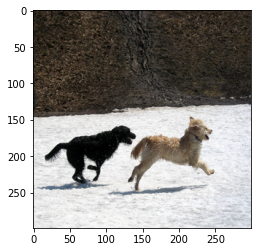

In [36]:
plt.imshow(get_image(train_list[0]))
img_decoder(enc_train[0])

['<START>',
 'a',
 'group',
 'of',
 'men',
 'are',
 'playing',
 'in',
 'a',
 'field',
 '.',
 '<END>']

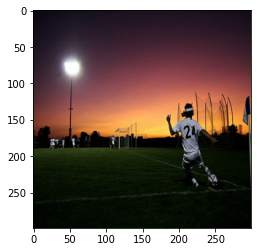

In [35]:
plt.imshow(get_image(dev_list[388]))
img_decoder(enc_dev[388])

##Beam Search

Instead of selecting the next word based on which word is most likely to appear next given the prior text and image, we can select the most probable sequence using Beam search.

In [38]:
def beam_decoder(n, image_enc):
  pairs = []
  sequence = np.zeros((1,MAX_LEN))
  sequence[0][0] = word_to_id['<START>']
  pvals = np.log(model.predict([np.array([image_enc]),sequence]))
  pvals_indices = (-pvals).argsort()
  for i in range(n):
    p = pvals[0][pvals_indices[0][i]]
    next = (p,sequence.copy())
    next[1][0][1] = pvals_indices[0][i]
    pairs.append(next)
  count = 1


  while count < MAX_LEN-1:
    #expand
    new_pairs = []
    for i in range(n): #for each entry
      pvals = np.log(model.predict([np.array([image_enc]),pairs[i][1]]))
      pvals_indices = (-pvals).argsort()
      for j in range(n):   #expand entry  
        index = pvals_indices[0][j]    
        p = pvals[0][index] + pairs[i][0]
        new_sequence = np.copy(pairs[i][1])
        new_sequence[0][count+1] = index
        new_pairs.append((p,new_sequence))

    #prune
    new_pairs.sort(key=lambda tup: tup[0],reverse=True)
    pairs = new_pairs[0:n]
    count += 1
  output = []
  for i,element in enumerate(pairs[0][1][0]):
    output.append(id_to_word[element])
                             

  return output


##Final Evaluation


RESULT 1:
Greedy output:
['<START>', 'a', 'boy', 'in', 'a', 'white', 'uniform', 'is', 'playing', 'a', 'game', '.', '<END>']

Beam search at n=3:
['<START>', 'a', 'man', 'in', 'a', 'white', 'uniform', 'and', 'a', 'white', 'uniform', 'is', 'playing', 'a', 'game', '.', '<END>', '.', '<END>', '<END>', '.', '<END>', '<END>', '.', '<END>', '.', '<END>', '<END>', '.', '<END>', '<END>', '.', '<END>', '<END>', '.', '<END>', '<END>', '.', '<END>', '<END>']

Beam search at n=5:
['<START>', 'a', 'man', 'in', 'a', 'white', 'uniform', 'and', 'a', 'white', 'uniform', 'is', 'playing', 'a', 'game', '.', '<END>', '.', '<END>', '<END>', '.', '<END>', '<END>', '.', '<END>', '.', '<END>', '<END>', '.', '<END>', '<END>', '.', '<END>', '<END>', '.', '<END>', '<END>', '.', '<END>', '<END>']



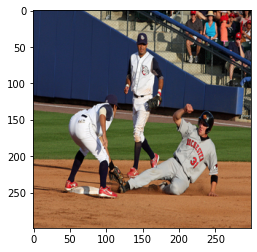

In [39]:
n = 100
g = img_decoder(enc_dev[n])
b3 = beam_decoder(3, enc_dev[n])
b5 = beam_decoder(5, enc_dev[n])
plt.imshow(get_image(dev_list[n]))
print()
print("RESULT 1:")
print('Greedy output:')
print(g)
print()
print('Beam search at n=3:')
print(b3)
print()
print('Beam search at n=5:')
print(b5)
print()


RESULT 5:
Greedy output:
['<START>', 'a', 'dog', 'is', 'running', 'through', 'a', 'grassy', 'field', '.', '<END>']

Beam search at n=3:
['<START>', 'a', 'dog', 'is', 'running', 'through', 'the', 'grass', '.', '<END>', '<END>', '.', '<END>', '<END>', '.', '<END>', '<END>', '.', '<END>', '<END>', '.', '<END>', '<END>', '.', '<END>', '<END>', '.', '<END>', '<END>', '.', '<END>', '<END>', '.', '<END>', '<END>', '.', '<END>', '<END>', '.', '<END>']

Beam search at n=5:
['<START>', 'a', 'brown', 'dog', 'is', 'running', 'through', 'the', 'grass', '.', '<END>', '<END>', '.', '<END>', '<END>', '.', '<END>', '<END>', '.', '<END>', '<END>', '.', '<END>', '<END>', '.', '<END>', '<END>', '.', '<END>', '<END>', '.', '<END>', '<END>', '.', '<END>', '<END>', '.', '<END>', '<END>', '<END>']



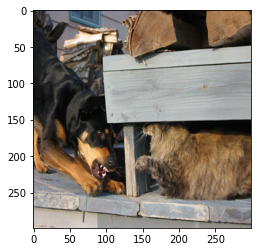

In [40]:
n = 899
g = img_decoder(enc_dev[n])
b3 = beam_decoder(3, enc_dev[n])
b5 = beam_decoder(5, enc_dev[n])
plt.imshow(get_image(dev_list[n]))
print()
print("RESULT 5:")
print('Greedy output:')
print(g)
print()
print('Beam search at n=3:')
print(b3)
print()
print('Beam search at n=5:')
print(b5)
print()


RESULT 4:
Greedy output:
['<START>', 'a', 'dog', 'is', 'running', 'through', 'a', 'grassy', 'field', '.', '<END>']

Beam search at n=3:
['<START>', 'a', 'white', 'dog', 'is', 'running', 'through', 'the', 'grass', '.', '<END>', '<END>', '.', '<END>', '<END>', '.', '<END>', '<END>', '.', '<END>', '<END>', '.', '<END>', '<END>', '.', '<END>', '<END>', '.', '<END>', '<END>', '.', '<END>', '<END>', '.', '<END>', '<END>', '.', '<END>', '<END>', '<END>']

Beam search at n=5:
['<START>', 'a', 'white', 'dog', 'is', 'running', 'through', 'the', 'grass', '.', '<END>', '<END>', '.', '<END>', '<END>', '.', '<END>', '<END>', '.', '<END>', '<END>', '.', '<END>', '<END>', '.', '<END>', '<END>', '.', '<END>', '<END>', '.', '<END>', '<END>', '.', '<END>', '<END>', '.', '<END>', '<END>', '<END>']



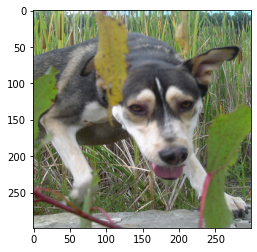

In [41]:
n = 33
g = img_decoder(enc_dev[n])
b3 = beam_decoder(3, enc_dev[n])
b5 = beam_decoder(5, enc_dev[n])
plt.imshow(get_image(dev_list[n]))
print()
print("RESULT 4:")
print('Greedy output:')
print(g)
print()
print('Beam search at n=3:')
print(b3)
print()
print('Beam search at n=5:')
print(b5)
print()


RESULT 4:
Greedy output:
['<START>', 'a', 'man', 'in', 'a', 'white', 'jacket', 'is', 'standing', 'on', 'a', 'rocky', 'hill', '.', '<END>']

Beam search at n=3:
['<START>', 'a', 'group', 'of', 'people', 'are', 'standing', 'on', 'a', 'mountain', '.', '<END>', '<END>', '.', '<END>', '<END>', '.', '<END>', '<END>', '.', '<END>', '<END>', '.', '<END>', '<END>', '.', '<END>', '<END>', '.', '<END>', '<END>', '.', '<END>', '<END>', '.', '<END>', '<END>', '.', '<END>', '<END>']

Beam search at n=5:
['<START>', 'a', 'group', 'of', 'people', 'are', 'standing', 'on', 'a', 'mountain', '.', '<END>', '<END>', '.', '<END>', '<END>', '.', '<END>', '<END>', '.', '<END>', '<END>', '.', '<END>', '<END>', '.', '<END>', '<END>', '.', '<END>', '<END>', '.', '<END>', '<END>', '.', '<END>', '<END>', '.', '<END>', '<END>']



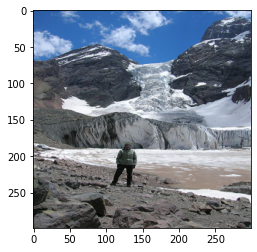

In [42]:
n = 555
g = img_decoder(enc_dev[n])
b3 = beam_decoder(3, enc_dev[n])
b5 = beam_decoder(5, enc_dev[n])
plt.imshow(get_image(dev_list[n]))
print()
print("RESULT 4:")
print('Greedy output:')
print(g)
print()
print('Beam search at n=3:')
print(b3)
print()
print('Beam search at n=5:')
print(b5)
print()


RESULT 4:
Greedy output:
['<START>', 'a', 'dog', 'is', 'running', 'through', 'the', 'water', '.', '<END>']

Beam search at n=3:
['<START>', 'a', 'dog', 'is', 'running', 'through', 'the', 'water', '.', '<END>', '<END>', '.', '<END>', '<END>', '.', '<END>', '<END>', '.', '<END>', '<END>', '.', '<END>', '<END>', '.', '<END>', '<END>', '.', '<END>', '<END>', '.', '<END>', '<END>', '.', '<END>', '<END>', '<END>', '.', '<END>', '<END>', '<END>']

Beam search at n=5:
['<START>', 'a', 'white', 'dog', 'is', 'running', 'through', 'the', 'water', '.', '<END>', '<END>', '.', '<END>', '<END>', '.', '<END>', '<END>', '.', '<END>', '<END>', '.', '<END>', '<END>', '.', '<END>', '<END>', '.', '<END>', '<END>', '.', '<END>', '<END>', '.', '<END>', '<END>', '<END>', '.', '<END>', '<END>']



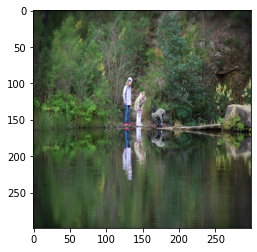

In [43]:
n = 489
g = img_decoder(enc_dev[n])
b3 = beam_decoder(3, enc_dev[n])
b5 = beam_decoder(5, enc_dev[n])
plt.imshow(get_image(dev_list[n]))
print()
print("RESULT 4:")
print('Greedy output:')
print(g)
print()
print('Beam search at n=3:')
print(b3)
print()
print('Beam search at n=5:')
print(b5)
print()